In [71]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import requests
import numpy as np
from json import loads
import json
from requests.exceptions import HTTPError
import pprint
from datetime import datetime
from dateutil.parser import parse
import lightgbm as lgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from bayes_opt import BayesianOptimization
import toolz

shap.initjs()
from IPython.display import display, clear_output
from bayes_opt import BayesianOptimization
import time


In [72]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [73]:
print(np.__version__)
print(lgb.__version__)

1.16.4
2.1.2


In [74]:
target_diff = 0.0025
stop_loss = 0.0025
profit = (target_diff / 0.0001)*0.75
loss = (stop_loss / 0.0001)*0.75


filename_date = '100919'


In [75]:
data = pd.read_csv('../data/' + filename_date + '_mds_out_final_v10_long.csv')
data.shape

# shift_fields = ['bid_o', 'bid_h','bid_l','bid_c','ask_o','ask_h','ask_l','ask_c']

# shift_counter = 24
# shift_counter_max = 24*7

# while shift_counter <= shift_counter_max:
#     for s in shift_fields:
#         col = s+'_past'+str(shift_counter)
#         data[col] = ((data[s] - data[s].shift(shift_counter)) / data[s].shift(shift_counter))*100
#         shift_counter+=24
# print(data.shape)

data['time'] = pd.to_datetime(data['time'])
data['hour'] = data['time'].dt.hour
data['day_of_week'] = data['time'].dt.dayofweek

In [76]:
mds = data.copy()


model_cols = list(mds)
# model_cols.remove('order')
model_cols.remove('time')
model_cols.remove('target_tp')
model_cols.remove('target_sl')
model_cols.remove('long_target')
model_cols.remove('short_target')
# model_cols.remove('g_diff')
# model_cols.remove('g_time_shift')
model_cols.remove('g_time')
model_cols.remove('l_time')
model_cols.remove('bucketwidth_x')
model_cols.remove('bucketwidth_y')
model_cols.remove('instrument')
model_cols.remove('instrument_x')
model_cols.remove('instrument_y')
model_cols.remove('match_time')
model_cols.remove('index')
model_cols.remove('g')
model_cols.remove('l')
model_cols.remove('ask_h')
model_cols.remove('ask_l')
model_cols.remove('ask_c')
model_cols.remove('ask_o')
model_cols.remove('bid_h')
model_cols.remove('bid_l')
model_cols.remove('bid_c')
model_cols.remove('bid_o')
model_cols.remove('volume')
model_cols.remove('diff')
model_cols.remove('same_time')
# model_cols.remove('time_diff')



for m in model_cols:
#     print(m)
    mds[m] = pd.to_numeric(mds[m])
    

mds_train = mds.copy()
# mds_train = mds[mds['time'] < '2019-01-01'].copy()

X_train, X_test, y_train, y_test = train_test_split(
     mds_train[model_cols], mds_train['long_target'], test_size=0.33, random_state=42)
     
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_test = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

print(mds_train.shape)
print(mds.shape)

(16278, 798)
(16278, 798)


In [77]:
def lgb_evaluate(num_leaves,
                 min_child_weight,
                 min_split_gain,
                 feature_fraction,
                 bagging_fraction,
                 bagging_freq,
                 lambda_l1,
                 lambda_l2,
                 min_data,
                 drop_rate,
                 skip_drop,
                 max_drop):

    params['num_leaves'] = int(num_leaves)
    params['min_child_weight'] = int(min_child_weight)
    params['feature_fraction'] = max(feature_fraction,0)
    params['min_split_gain'] = max(min_split_gain, 0)
    params['bagging_fraction'] = max(bagging_fraction,0)
    params['bagging_freq'] = int(bagging_freq)
    params['lambda_l2'] = max(lambda_l2, 0)
    params['lambda_l1'] = max(lambda_l1, 0)
    params['min_data'] = int(min_data)
    params['metric'] = 'binary_logloss'
    params['eta'] = 0.1
    params['boost_from_average'] = False
    params['is_unbalance'] = False
    params['num_threads'] = 2
    params['boosting_type']= 'dart'
    params['skip_drop'] = max(skip_drop,0)
    params['drop_rate'] = max(drop_rate,0)
    params['max_drop'] = int(max_drop)

    cv_result = lgb.cv(params, lgb_train, num_boost_round=num_rounds, nfold=3,
             seed=random_state, early_stopping_rounds=500, verbose_eval=50)

    return -cv_result['binary_logloss-mean'][-1]

In [78]:
# num_rounds = 3000
# random_state = 2016
# num_iter = 25
# init_points = 25
# params = {
#     'eta': 0.1,
# #     'silent': 1,
# #     'eval_metric': 'auc',
# #     'verbose_eval': True,
# #     'seed': random_state
# }

# lgbBO = BayesianOptimization(lgb_evaluate, {'num_leaves': (5, 100),
#                                             'min_child_weight': (0, 5),
#                                             'min_split_gain': (0, 5),
#                                             'feature_fraction': (0.1, 1),
#                                             'bagging_fraction': (0.1, 1),
#                                             'bagging_freq': (1, 10),
#                                             'lambda_l2': (0, 1),
#                                             'lambda_l1': (0, 1),
#                                             'min_data': (1,100),
#                                             'drop_rate': (0.1, 0.9),
#                                             'skip_drop': (0.1, 0.9),
#                                             'max_drop': (1,100)
#                                             })

# lgbBO.maximize(init_points=init_points, n_iter=num_iter)

In [79]:
# tracker = {'max':1, 'idx':1000}
# counter = 0
# for f in lgbBO.res:
#     if abs(f['target']) < tracker['max']:
#         tracker['max'] = abs(f['target'])
#         tracker['idx'] = counter
#     counter +=1
    
# best_params = lgbBO.res[tracker['idx']]['params']
# print(tracker)
# print()
# best_params

In [80]:
params = {
        'objective':'binary',
#         'boosting': 'dart',
#         'drop_rate': 0.5,
#         'max_drop': 50,
#         'skip_drop':0.25,
#         'uniform_drop': False,
        'boost_from_average': False,
        'learning_rate': 0.5,
        'min_data': 50,
        'num_leaves': 20,
#         'max_depth':6,
#         'lambda_l2': 0.1,
#         'lambda_l1': 0.1,
        'bagging_fraction': 0.75,
        'bagging_freq': 1,
        'min_child_weight': 1,
#         'min_split_gain': 1,
        'verbose': 1,
        'feature_fraction': 0.5,
#         'scale_pos_weight': 100,
#         'is_unbalance': True,
        'metric': ['binary_logloss'],
        'max_bin': 63,
        'num_threads': 2
    } 


# params = {
#     'objective':'binary',
#     'boosting_type': 'dart',
#     'drop_rate': round(best_params['drop_rate'], 2),
#     'max_drop': int(best_params['max_drop']),
#     'skip_drop':  round(best_params['skip_drop'], 2),   
#     'boost_from_average': False,
#     'learning_rate':  0.05,
#     'max_depth': int(best_params['max_depth']),
#     'num_leaves': int(best_params['num_leaves']),
#     'lambda_l2': best_params['lambda_l2'],
#     'lambda_l1': best_params['lambda_l1'],
#     'bagging_fraction':  round(best_params['bagging_fraction'], 2),
#     'bagging_freq': int(best_params['bagging_freq']),
#     'min_data': int(best_params['min_data']),
#     'min_child_weight':  round(best_params['min_child_weight'], 2),
#     'min_split_gain':  round(best_params['min_split_gain'], 2),
#     'verbose': 1,
#     'feature_fraction': round(best_params['feature_fraction'], 2),
# #     'scale_pos_weight': lgbBO.res['max']['max_params']['scale_pos_weight'],
#     'metric': ['binary_error'],
#     'num_threads': 2,
# #     'is_unbalance': True,
# } 


In [81]:
num_round = 100000
lgb_model = lgb.train(params, lgb_train, num_round, valid_sets=[lgb_test], early_stopping_rounds=500, verbose_eval=50, keep_training_booster=True)

Training until validation scores don't improve for 500 rounds.
[50]	valid_0's binary_logloss: 0.523505
[100]	valid_0's binary_logloss: 0.486507
[150]	valid_0's binary_logloss: 0.46209
[200]	valid_0's binary_logloss: 0.465037
[250]	valid_0's binary_logloss: 0.461058
[300]	valid_0's binary_logloss: 0.461874
[350]	valid_0's binary_logloss: 0.46457
[400]	valid_0's binary_logloss: 0.470723
[450]	valid_0's binary_logloss: 0.474486
[500]	valid_0's binary_logloss: 0.483641
[550]	valid_0's binary_logloss: 0.490284
[600]	valid_0's binary_logloss: 0.49824
[650]	valid_0's binary_logloss: 0.504182
[700]	valid_0's binary_logloss: 0.513873
Early stopping, best iteration is:
[237]	valid_0's binary_logloss: 0.457298


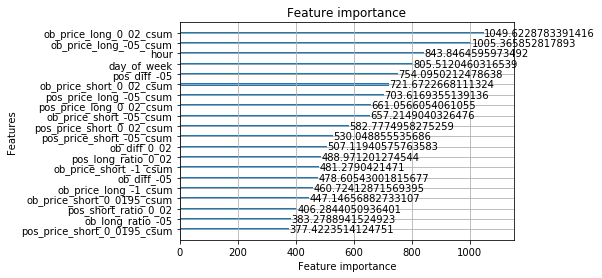

In [82]:
lgb.plot_importance(lgb_model, importance_type='gain', max_num_features=20)

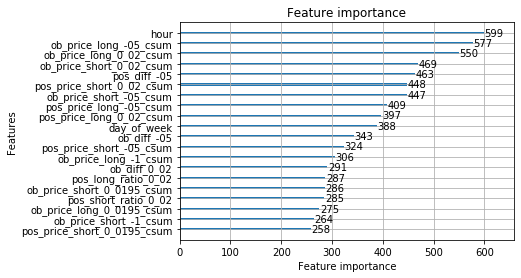

In [83]:
lgb.plot_importance(lgb_model, importance_type='split', max_num_features=20)

In [84]:
def tf_to_bin(value):
    if value:
        return 1
    else:
        return 0

In [85]:
mds = pd.read_csv('../data/' + filename_date + '_mds_out_final_v10_long_live.csv')
mds.shape

shift_fields = ['bid_o', 'bid_h','bid_l','bid_c','ask_o','ask_h','ask_l','ask_c']

shift_counter = 24
shift_counter_max = 24*7

while shift_counter <= shift_counter_max:
    for s in shift_fields:
        col = s+'_past'+str(shift_counter)
        mds[col] = ((mds[s] - mds[s].shift(shift_counter)) / mds[s].shift(shift_counter))*100
        shift_counter+=24
        
print(mds.shape)

mds['time'] = pd.to_datetime(mds['time'])
mds['month'] = mds['time'].dt.month
mds['hour'] = mds['time'].dt.hour
mds['day_of_week'] = mds['time'].dt.dayofweek

for m in model_cols:
#     print(m)
    mds[m] = pd.to_numeric(mds[m])
    
# mds['time']
    
mds = mds[mds['time'] >= '2019-01-01']
# mds.shape

(1996, 804)


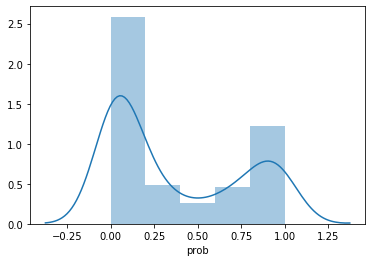

In [86]:
mds['prob'] =  lgb_model.predict(mds[model_cols])
sns.distplot(mds['prob'])

In [87]:
prob_df = pd.DataFrame()
counter = 1
for t in np.arange(0.1, 0.9, 0.0025):
    temp_test = mds.copy()
    temp_test['prob'] =  lgb_model.predict(temp_test[model_cols])
    temp_test['pred'] = temp_test['prob'].apply(lambda x: 1 if x >= t else 0)
    temp_test['tp'] = (temp_test['pred'] == 1) & (mds['long_target'] == 1)
    temp_test['fp'] = (temp_test['pred'] == 1) & (mds['long_target'] == 0)
    temp_test['tn'] = (temp_test['pred'] == 0) & (mds['long_target'] == 0)
    temp_test['fn'] = (temp_test['pred'] == 0) & (mds['long_target'] == 1)
    
    temp = pd.DataFrame()
    temp['cutoff'] = [t]
    temp['total_target'] = mds['long_target'].value_counts()[1]
    temp['tp_cnt'] =  temp_test['tp'].sum()
    temp['fp_cnt'] =  temp_test['fp'].sum()
    temp['tp_pct'] = (temp_test['tp'].sum() / temp_test[['tp', 'fp']].sum().sum())*100
    temp['fp_pct'] = (temp_test['fp'].sum() / temp_test[['tp', 'fp']].sum().sum())*100
    temp['tp_pct_total'] = (temp_test['tp'].sum() / temp_test[['tp', 'fn']].sum().sum())*100
    if counter == 1:
        prob_df = temp
        counter +=1
    else:
        prob_df = prob_df.append(temp)
        
prob_df['pct_diff'] = prob_df['tp_pct'] - prob_df['fp_pct']
prob_df['pct_diff'] = prob_df['tp_pct'] - prob_df['fp_pct']
prob_df['pl'] = (prob_df['tp_cnt'] * profit) - (prob_df['fp_cnt'] * loss)
positive = prob_df[prob_df['pl'] > 0].copy()
try:
    target_cutoff = positive[positive['pl'] == positive['pl'].max()]['cutoff'].values
    target_cutoff = target_cutoff[len(target_cutoff)-1]
except IndexError:
    print('error')
    target_cutoff= 0.5
# positive = prob_df[prob_df['pct_diff'] > 1].copy()
# target_cutoff_min = positive['cutoff'].min()
# target_cutoff_max = positive['cutoff'].max()
target_cutoff

0.49500000000000033

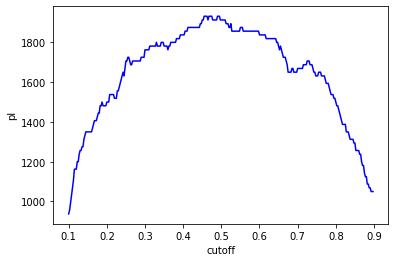

In [88]:
sns.lineplot(x='cutoff', y='pl', data=prob_df,  color='b')

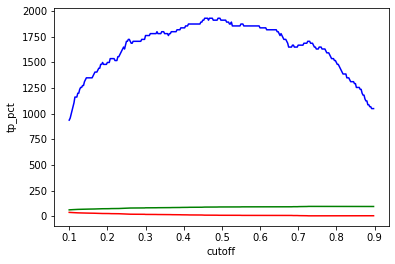

In [89]:
sns.lineplot(x='cutoff', y='pl', data=prob_df[prob_df['pl'] > 0],  color='b')
sns.lineplot(x='cutoff', y='fp_pct', data=prob_df[prob_df['pl'] > 0],  color='r')
sns.lineplot(x='cutoff', y='tp_pct', data=prob_df[prob_df['pl'] > 0],  color='g')

In [90]:
# mds = mds[mds['time'] >= '2019-01-01']
# mds.shape

0.49500000000000033
(127, 819)
End PL - $1931.25


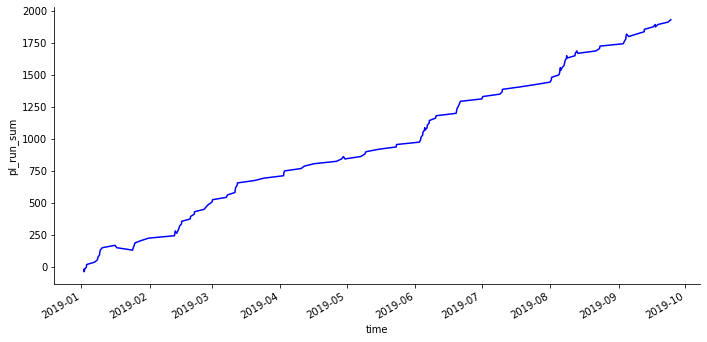

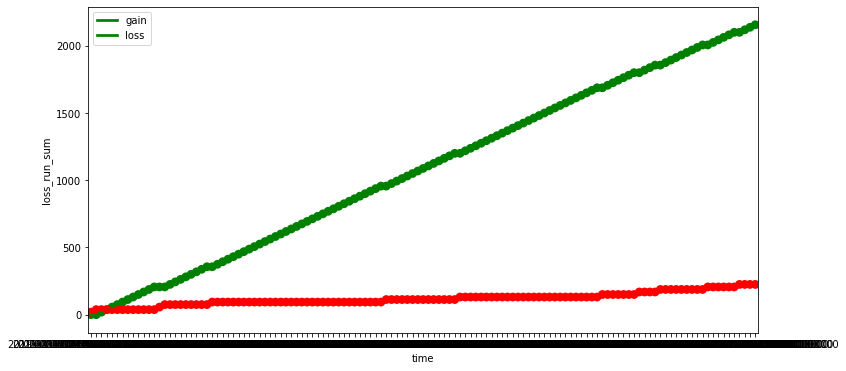

In [91]:
print(target_cutoff)
mds['prob'] = lgb_model.predict(mds[model_cols])
mds['pred'] = mds.apply(lambda x: 1 if x.prob >= target_cutoff else 0, axis=1)
mds['tp'] = (mds['pred'] == 1) & (mds['long_target'] == 1)
mds['fp'] = (mds['pred'] == 1) & (mds['long_target'] == 0)
mds['tn'] = (mds['pred'] == 0) & (mds['long_target'] == 0)
mds['fn'] = (mds['pred'] == 0) & (mds['long_target'] == 1)

mds['tp'] = mds['tp'].apply(tf_to_bin)
mds['fp'] = mds['fp'].apply(tf_to_bin)
mds['tn'] = mds['tn'].apply(tf_to_bin)
mds['fn'] = mds['fn'].apply(tf_to_bin)

tp = mds[mds['tp'] == 1].copy()
tp['pl'] = profit
tp['gain'] = profit
tp['loss'] = 0

fp = mds[mds['fp'] == 1].copy()
fp['pl'] = -loss
fp['gain'] = 0
fp['loss'] = loss

pl_df = pd.concat([tp, fp], axis=0)
pl_df['time'] = pd.to_datetime(pl_df['time'])
pl_df = pl_df.sort_values(by='time')
pl_df['pl_run_sum'] = pl_df['pl'].cumsum()
pl_df['gain_run_sum'] = pl_df['gain'].cumsum()
pl_df['loss_run_sum'] = pl_df['loss'].cumsum()
print(pl_df.shape)
print('End PL - ' + '$'+ str(pl_df['pl_run_sum'].tail(1).values[0]))

g = sns.relplot(x="time", y="pl_run_sum", kind="line", color='b', data=pl_df, height=5, aspect=2)
g.fig.autofmt_xdate()

fig, ax = plt.subplots(figsize=(12, 6))
sns.pointplot(x='time', y='gain_run_sum', data=pl_df, color='g')
sns.pointplot(x='time', y='loss_run_sum', data=pl_df, color='r')
plt.legend(['gain', 'loss'])
plt.show()

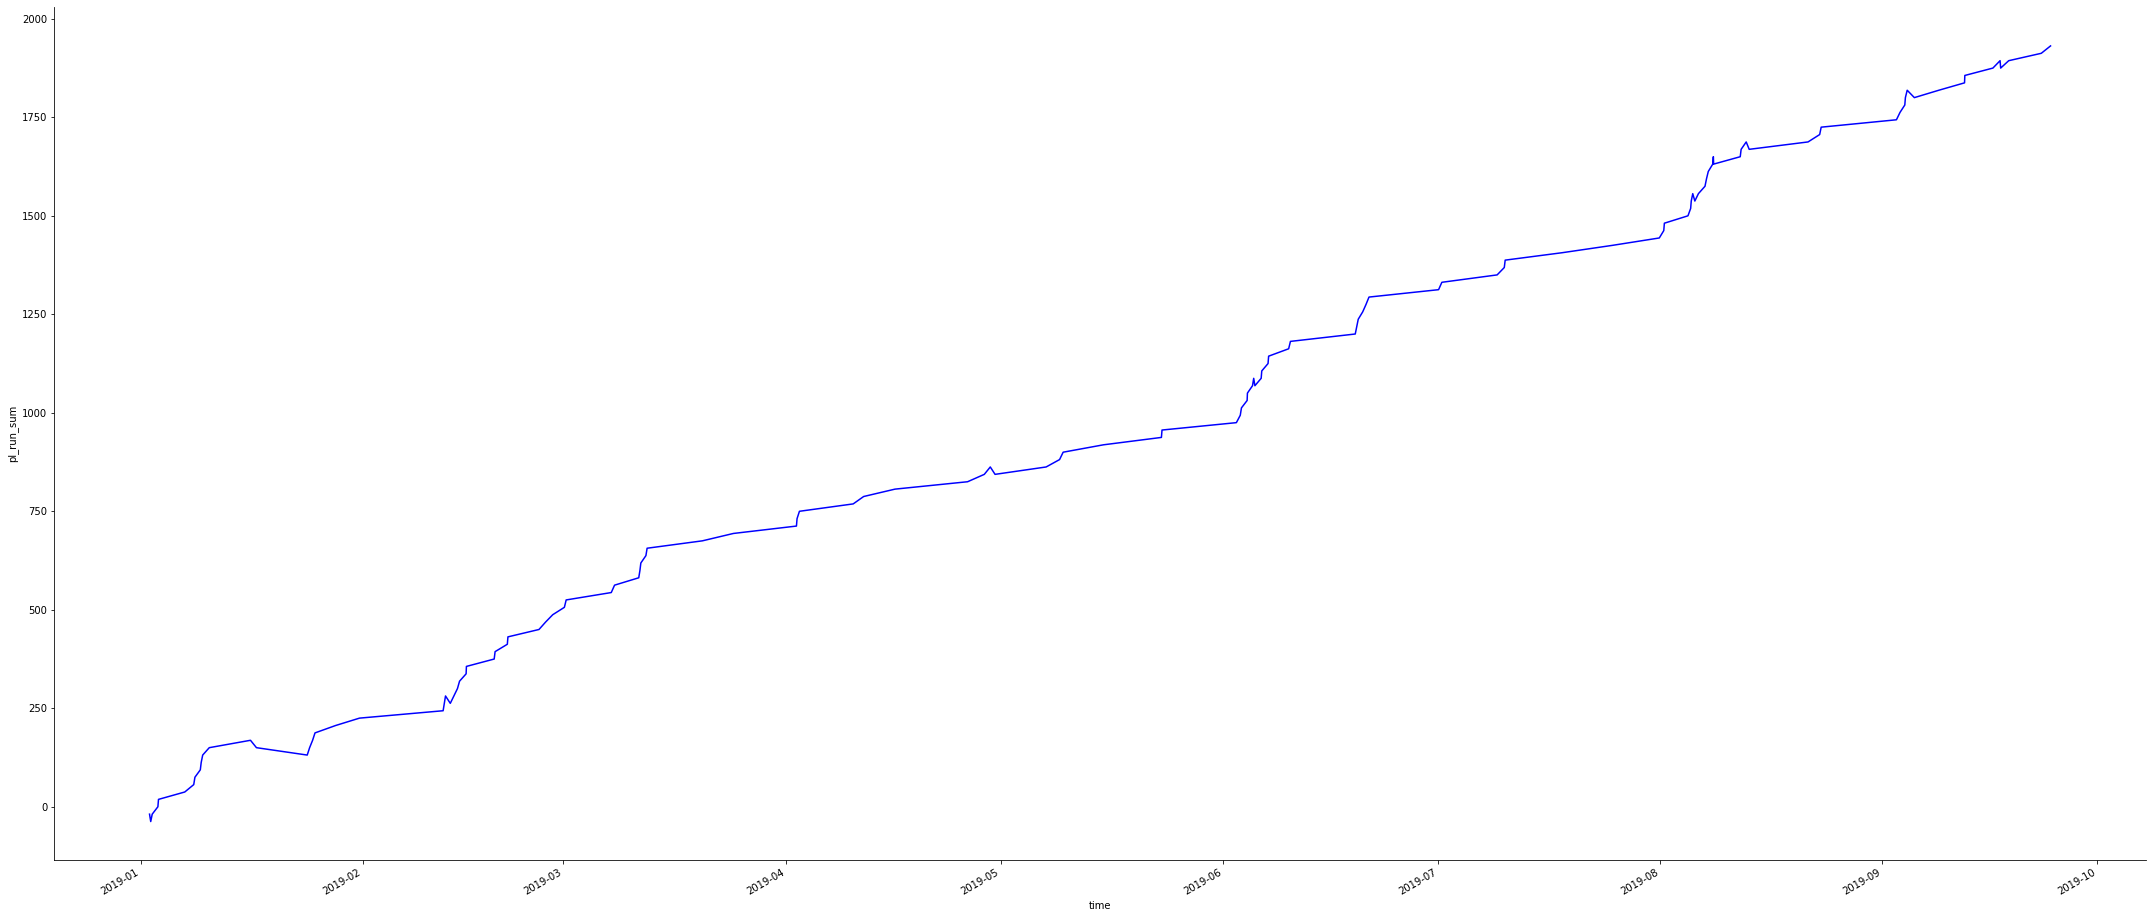

In [92]:
g = sns.relplot(x="time", y="pl_run_sum", kind="line", color='b', data=pl_df, height=15, aspect=2)
g.fig.autofmt_xdate()

In [93]:
tp_cnt = 0
fp_cnt = 0

pl_df = pl_df.reset_index(drop=True)
pl_df['index'] = pl_df.index
pl_df['tp_up1'] = pl_df['tp'].shift(1)
pl_df['fp_up1'] = pl_df['fp'].shift(1)
pl_df['win_streak'] = 0
pl_df['losing_streak'] = 0
pl_df['tp_runsum'] = pl_df['tp'].cumsum()


for idx, row in pl_df.iterrows():
    if row['tp'] == 1 and row['tp_up1'] != 1.0:
        pl_df.loc[idx, 'win_streak'] = row['win_streak'] +1
        
    elif row['tp'] == 1  and  row['tp_up1'] == 1.0:
        pl_df.loc[idx, 'win_streak'] = pl_df.loc[idx-1, 'win_streak'] +1

    else:
        pl_df.loc[idx, 'win_streak'] = 0
        
    if row['fp'] == 1 and row['fp_up1'] != 1.0:
        pl_df.loc[idx, 'losing_streak'] = row['win_streak'] +1
        
    elif row['fp'] == 1  and  row['fp_up1'] == 1.0:
        pl_df.loc[idx, 'losing_streak'] = pl_df.loc[idx-1, 'losing_streak'] +1

    else:
        pl_df.loc[idx, 'losing_streak'] = 0

win_streak_start = 1
loss_streak_stop = 1
trade_cols = ['time', 'tp', 'fp', 'win_streak', 'losing_streak', 'pl', 'live_pl', 'pl_run_sum', 'gain_run_sum', 'loss_run_sum']
trade_df = pd.DataFrame(columns=trade_cols)
idx_counter = 0
while idx_counter <= pl_df.index.max():
    safe = True
    failed = False
    while not failed:
        if idx_counter <= pl_df.index.max():
            temp = pl_df[pl_df['index'] == idx_counter].copy()
            if temp['losing_streak'].values[0] <= loss_streak_stop:
                temp['live_pl'] = temp['pl'].values[0]
                trade_df = trade_df.append(temp[trade_cols])
                idx_counter+=1
                tp_cnt+=1
            else:
                temp['live_pl'] = 0
                trade_df = trade_df.append(temp[trade_cols])
                idx_counter+=1
                failed = True
                fp_cnt+=1
        else:
            failed = True
#             fp_cnt+=1

    while failed:
        if idx_counter <= pl_df.index.max():
            temp = pl_df[pl_df['index'] == idx_counter].copy()
            if temp['win_streak'].values[0] <= win_streak_start:
                temp['live_pl'] = 0
                trade_df = trade_df.append(temp[trade_cols])
                idx_counter+=1
#                 fp_cnt+=1
            else:
                temp['live_pl'] = temp['pl'].values[0]
                trade_df = trade_df.append(temp[trade_cols])
                idx_counter+=1 
                failed = False
#                 tp_cnt+1
        else:
            failed = False
#             tp_cnt+=1
            
for c in list(trade_df):
    if c != 'time':
        trade_df[c] = pd.to_numeric(trade_df[c])

trade_df['live_pl_run_sum'] = trade_df['live_pl'].cumsum()
trade_df['time'] = pd.to_datetime(trade_df['time'])

# g = sns.relplot(x="time", y="pl_run_sum", kind="line", color='b', data=trade_df, height=5, aspect=2)
# g.fig.autofmt_xdate()

print('orig total - $'  + str(trade_df['pl_run_sum'].tail(1).values[0]))
print('new total  - $' + str(trade_df['live_pl_run_sum'].tail(1).values[0]))

print(tp_cnt, fp_cnt)

orig total - $1931.25
new total  - $1931.25
121 2


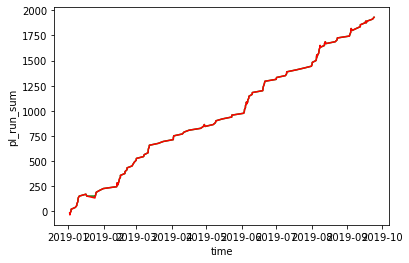

In [94]:
sns.lineplot(x='time', y='live_pl_run_sum', data=trade_df, color='g')
sns.lineplot(x='time', y='pl_run_sum', data=trade_df, color='r')

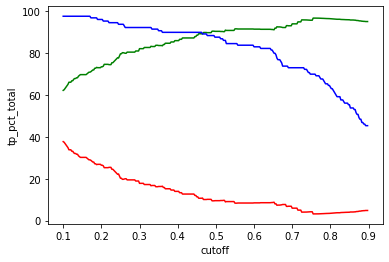

In [95]:
sns.lineplot(x='cutoff', y='tp_pct', data=prob_df, color='g')
sns.lineplot(x='cutoff', y='fp_pct', data=prob_df, color='r')
sns.lineplot(x='cutoff', y='tp_pct_total', data=prob_df, color='b')

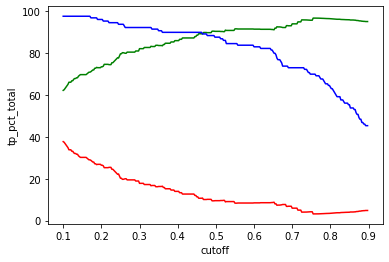

In [96]:
sns.lineplot(x='cutoff', y='tp_pct', data=positive, color='g')
sns.lineplot(x='cutoff', y='fp_pct', data=positive, color='r')
sns.lineplot(x='cutoff', y='tp_pct_total', data=positive, color='b')

In [97]:
mds['prob'] = lgb_model.predict(mds[model_cols])
mds['pred'] = mds.apply(lambda x: 1 if x.prob >= target_cutoff else 0, axis=1)
mds['tp'] = (mds['pred'] == 1) & (mds['long_target'] == 1)
mds['fp'] = (mds['pred'] == 1) & (mds['long_target'] == 0)
mds['tn'] = (mds['pred'] == 0) & (mds['long_target'] == 0)
mds['fn'] = (mds['pred'] == 0) & (mds['long_target'] == 1)

mds['tp'] = mds['tp'].apply(tf_to_bin)
mds['fp'] = mds['fp'].apply(tf_to_bin)
mds['tn'] = mds['tn'].apply(tf_to_bin)
mds['fn'] = mds['fn'].apply(tf_to_bin)

print(mds.shape)

tp = mds[mds['tp'] == 1].copy()
tp['pl'] = profit
tp['gain'] = profit
tp['loss'] = 0

fp = mds[mds['fp'] == 1].copy()
fp['pl'] = -loss
fp['gain'] = 0
fp['loss'] = loss

tn = mds[mds['tn'] == 1].copy()
tn['pl'] = 0
tn['gain'] = 0
tn['loss'] = 0

fn = mds[mds['fn'] == 1].copy()
fn['pl'] = 0
fn['gain'] = 0
fn['loss'] = 0

mds = pd.concat([tp, fp, tn, fn], axis=0)
mds = mds.sort_values(by='time')
print(mds.shape)

(352, 813)
(352, 816)


In [98]:
mcnt = mds.groupby(['month', 'tp', 'fp', 'fn', 'tn']).size().reset_index()
mcnt.columns = ['month', 'tp', 'fp', 'fn', 'tn', 'count']
mcnt.tail(15)

,month,tp,fp,fn,tn,count
16,5,1,0,0,0,6
17,6,0,0,0,1,21
18,6,0,0,1,0,2
19,6,0,1,0,0,1
20,6,1,0,0,0,19
21,7,0,0,0,1,28
22,7,0,0,1,0,1
23,7,1,0,0,0,8
24,8,0,0,0,1,26
25,8,0,1,0,0,3


In [99]:
pl_check = pd.concat([tp, fp], axis=0)

In [100]:
pl_check.groupby('month')['pl'].agg(['median', 'mean', 'sum', 'min', 'max', 'count'])

,median,mean,sum,min,max,count
month,,,,,,
1,18.75,11.250000,225.00,-18.75,18.75,20
2,18.75,16.406250,262.50,-18.75,18.75,16
3,18.75,18.750000,206.25,18.75,18.75,11
4,18.75,15.000000,150.00,-18.75,18.75,10
5,18.75,18.750000,112.50,18.75,18.75,6
6,18.75,16.875000,337.50,-18.75,18.75,20
7,18.75,18.750000,150.00,18.75,18.75,8
8,18.75,13.392857,281.25,-18.75,18.75,21
9,18.75,13.750000,206.25,-18.75,18.75,15


In [101]:
pl_check.groupby('day_of_week')['pl'].agg(['median', 'mean', 'sum', 'min', 'max', 'count'])

,median,mean,sum,min,max,count
day_of_week,,,,,,
0,18.75,17.045455,375.00,-18.75,18.75,22
1,18.75,14.423077,375.00,-18.75,18.75,26
2,18.75,13.750000,412.50,-18.75,18.75,30
3,18.75,13.911290,431.25,-18.75,18.75,31
4,18.75,18.750000,243.75,18.75,18.75,13
6,18.75,18.750000,93.75,18.75,18.75,5


In [102]:
pl_check.groupby('hour')['pl'].agg(['median', 'mean', 'sum', 'count'])

,median,mean,sum,count
hour,,,,
0,18.75,18.750000,37.50,2
2,18.75,18.750000,18.75,1
3,18.75,18.750000,75.00,4
4,18.75,12.500000,75.00,6
5,18.75,8.035714,56.25,7
6,18.75,10.416667,93.75,9
7,18.75,18.750000,75.00,4
8,18.75,18.750000,206.25,11
9,18.75,18.750000,150.00,8


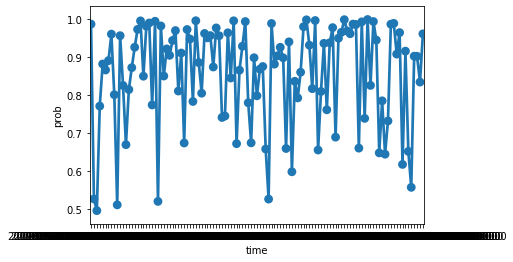

In [103]:
sns.pointplot(x='time', y='prob', data=tp)

In [104]:
tp['time'].tail(10)

877   2019-09-04 05:00:00
878   2019-09-04 11:00:00
880   2019-09-08 21:00:00
883   2019-09-12 11:00:00
884   2019-09-12 12:00:00
885   2019-09-16 10:00:00
886   2019-09-17 10:00:00
887   2019-09-18 15:00:00
888   2019-09-23 04:00:00
889   2019-09-24 11:00:00
Name: time, dtype: datetime64[ns]

In [105]:
#Precision
print(mds[['tp']].sum() / mds[['tp', 'fp']].sum().sum())
print()
print(mds[['tp']].sum() / mds[['tp', 'fn']].sum().sum())

tp    0.905512
dtype: float64

tp    0.884615
dtype: float64


In [106]:
mds.groupby(['tp', 'fp', 'tn', 'fn']).size()

tp  fp  tn  fn
0   0   0   1      15
        1   0     210
    1   0   0      12
1   0   0   0     115
dtype: int64

In [107]:
62*30

1860

In [108]:
27*6

162

In [109]:
1860-162

1698

In [110]:
41*30

1230

In [111]:
103*5

515

In [112]:
t = mds[mds['long_target'] == 1]
t['prob'].describe()

count    130.000000
mean       0.785503
std        0.238626
min        0.003952
25%        0.674037
50%        0.873549
75%        0.961666
max        0.999597
Name: prob, dtype: float64

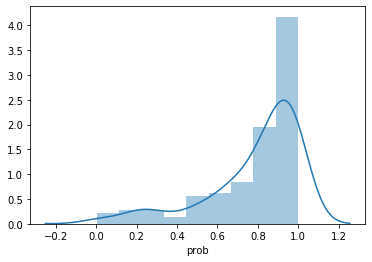

In [113]:
sns.distplot(t['prob'])

In [114]:
t['index'].min()

11873

In [115]:
t['index'].max()

16406

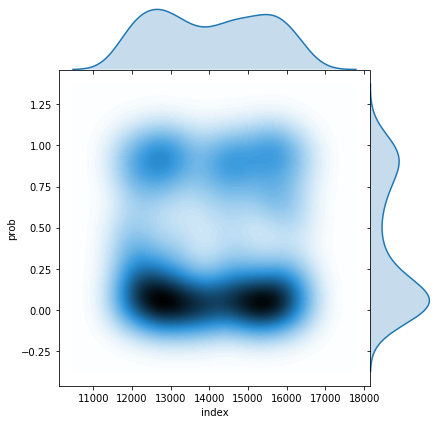

In [116]:
sns.jointplot(x='index', y='prob', data=mds, kind='kde', n_levels=100, space=0, zorder=0)

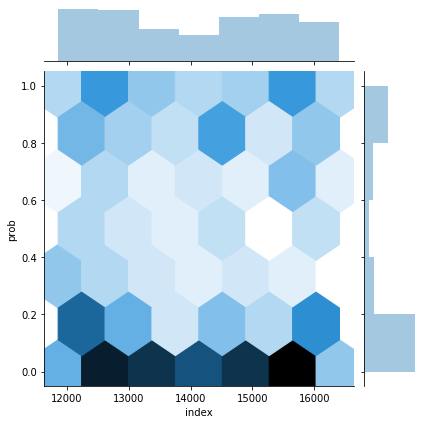

In [117]:
g = sns.jointplot(x='index', y='prob', data=mds, kind='hex')
g.savefig("probs_hex.png")

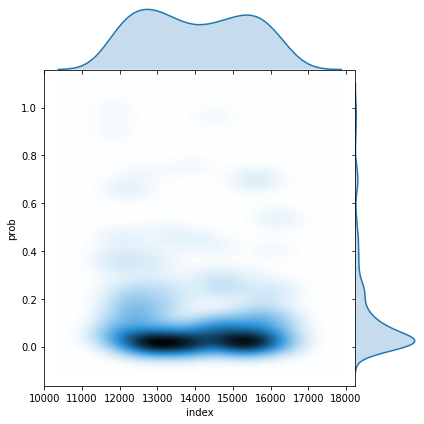

In [118]:
g = sns.jointplot(x='index', y='prob', data=mds[mds['long_target'] != 1], kind='kde', n_levels=100, space=0, zorder=0)
g.savefig("probs_fp_kde.png")

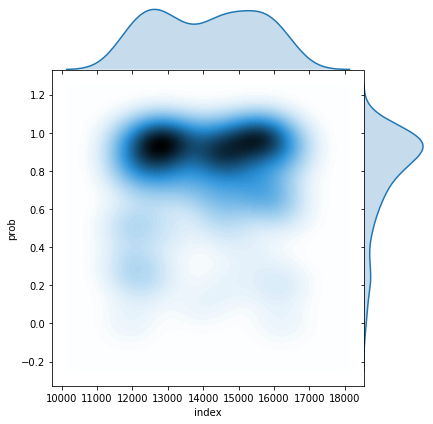

In [119]:
g = sns.jointplot(x='index', y='prob', data=mds[mds['long_target'] == 1], kind='kde', n_levels=100, space=0, zorder=0)
g.savefig("probs_tp_kde.png")

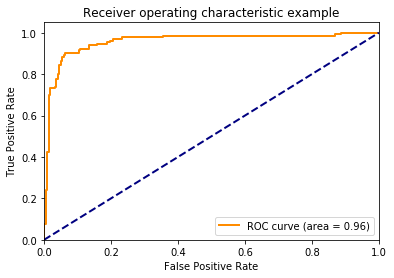

In [120]:
fpr, tpr, _ = roc_curve(mds['long_target'].values, mds['prob'].values )
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [121]:
features = list(X_train)
X = X_train.apply(pd.to_numeric).values
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X)

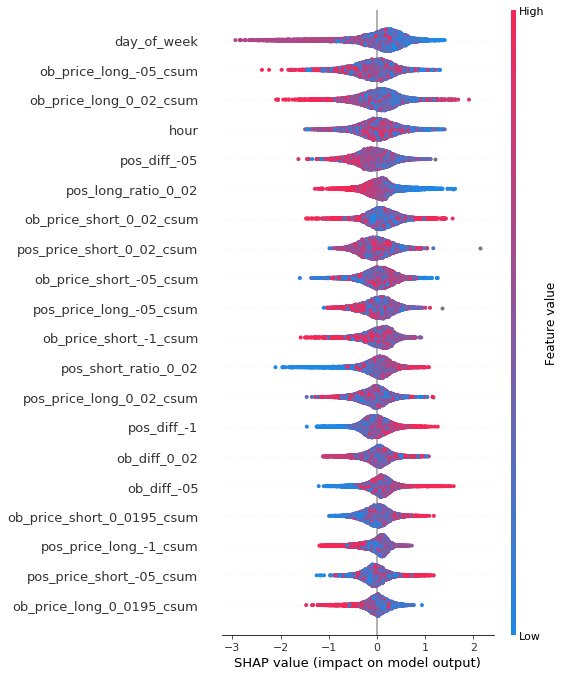

In [122]:
shap.summary_plot(shap_values, X_train, features)

In [123]:
def get_top_feats(shap_values, num_feats):
    feature_order = np.argsort(np.sum(np.abs(shap_values), axis=0)[:-1])
    feature_order = list(feature_order[-min(num_feats,len(feature_order)):])
    feature_order = feature_order[::-1]
    return list(X_train.iloc[:,feature_order])

top_feats = get_top_feats(shap_values, 5)
top_feats

['day_of_week',
 'ob_price_long_-05_csum',
 'ob_price_long_0_02_csum',
 'hour',
 'pos_diff_-05']

In [124]:
# shap.dependence_plot('hour', shap_values, X, X_train.columns, interaction_index='auto',
#                              alpha=0.5, dot_size=5, show=False)

In [125]:
# shap.dependence_plot('day_of_week', shap_values, X, X_train.columns, interaction_index='auto',
#                              alpha=0.5, dot_size=5, show=False)


day_of_week


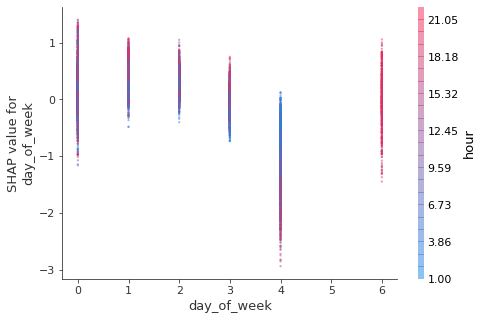

ob_price_long_-05_csum


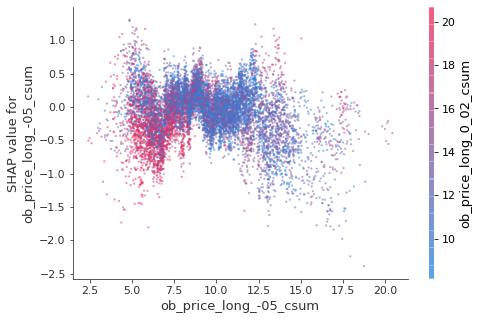

ob_price_long_0_02_csum


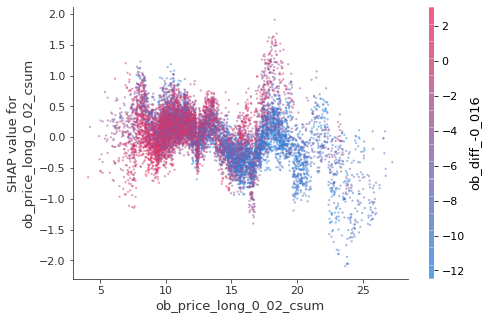

hour


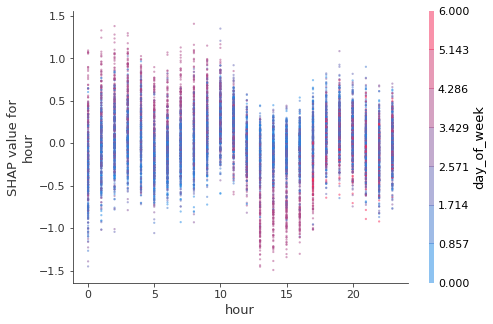

pos_diff_-05


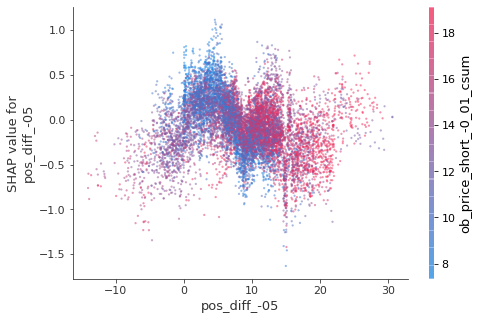

In [126]:
for name in top_feats:
    print(name)
    shap.dependence_plot(name, shap_values, X, X_train.columns, interaction_index='auto',
                             alpha=0.5, dot_size=5, show=False)
    plt.show()

In [127]:
# result_df = result_df.sort_values(by='time')
# result_df = result_df.reset_index(drop=True)
# result_df['id'] = result_df.index
# result_df.to_csv('long_preds_v3.csv', index=False, header=True)

In [128]:
# lgb_model.save_model('../model/oanda_EURUSD_long_v10_long.txt', num_iteration=-1)
# layout_df = pd.DataFrame(list(X_train), columns=['features'])
# layout_df.to_csv('../model/oanda_EURUSD_long_v10_layout_long.csv', index=False, header=True)

# info_df = pd.DataFrame()
# info_df['long_target_diff'] = [target_diff]
# info_df['long_stop_loss'] = stop_loss
# info_df['l_target_cutoff'] = target_cutoff
# info_df['l_profit'] = profit
# info_df['l_loss'] = loss

# info_df.to_csv('../model/oanda_EURUSD_long_v10_info_long.csv', index=False, header=True)

In [129]:
# mds[['time', 'long_target', 'prob', 'pred', 'tp', 'fp', 'tn', 'fn', 'pl', 'gain', 'loss']].to_csv('../data/oanda_EURUSD_long_v10_long_preds.csv', index=False)

In [130]:
profit

18.75